In [93]:
# #install jupyter lib
# %pip install jupyter

# Import the NetworkX package
import networkx as nx

# #store all paths passing a node
# nodeFrequentPaths = dict()


### Degree Centrality of All Nodes
`neighborNodesDegree(G, U)` accepts a graph `G` and individual neighbor nodes `U` of node `V` and returns the sum of the degrees of the neighbor node `U` and its neighbors.

`centralityOfNodes(G)` accepts a graph `G` and return a dictionary of all nodes `V` and their centralities in the graph.

In [94]:
def neighborNodesDegree(G, U):
    degU = G.degree(U) #degree of U

    for w in G.neighbors(U):
        degU += G.degree(w)
    
    return degU

def centralityOfNodes(G):
    centralities = dict()

    #find the centralities of all nodes
    for V in G.nodes():
        degV = G.degree(V) #degree of V

        for U in G.neighbors(V):
            degV += neighborNodesDegree(G, U)
        
        #save centrality of each V
        centralities[V] = degV
    
    return centralities
    

### Fuzzy Relation and NGC

In [95]:
import operator

def temporalFuzzyRelations(G, V):
    Xtemp = 0
    #store not visited nodes
    tempFuzzies = dict()
    
    len_vn = len(sorted(G.neighbors(V))) #length of node v neighbors

    for X in G.neighbors(V):
        vx_cn = nx.common_neighbors(G, V, X) #common neighbors(cn) of both V and X
        Xtemp = (1 + len(sorted(vx_cn))) / len_vn
        tempFuzzies[X] = Xtemp

    return tempFuzzies

def findNGCandFuzzyRelation(G, V):
    findtag = False
    W = V
    fuzzyrelation = 0
    closeTable = dict()
        
    #retrieve dictionary of node centralities
    nodeCentralities = centralityOfNodes(G) 

    #retrieve dictionary of temporal fuzzy relations
    openTable = temporalFuzzyRelations(G, V)

    while len(openTable) != 0:
        #take node with maximum temporal fuzzy relation
        C = max(openTable.items(), key=operator.itemgetter(1))[0]

        #if we don't have an NGC
        if findtag == False:
            if nodeCentralities.get(C, 0) > nodeCentralities.get(V, 0):
                W = C
                fuzzyrelation = openTable.get(C)
                findtag = True
        else:
            if openTable.get(C) < fuzzyrelation:
                break

            if nodeCentralities.get(C, 0) > nodeCentralities.get(W, 0):
                W = C
                fuzzyrelation = openTable.get(C)
    
        closeTable[C] = openTable.get(C)

        #remove node and its value but return value -> default to return None to prevent KeyError
        CtmpFR = openTable.pop(C, None) 

        len_cn = len(sorted(G.neighbors(C))) #length of node c neighbors
        currentfr = 0

        for Y in G.neighbors(C):
            cy_cn = nx.common_neighbors(G, C, Y) #common neighbors(cn) of both C and Y
            currentfr = (1 + len(sorted(cy_cn))) / len_cn
            currentfr *= CtmpFR

            openTableContainsY = openTable.get(Y, None)
            closeTableContainsY = closeTable.get(Y, None)
            if openTableContainsY == None and closeTableContainsY == None:
                openTable[Y] = currentfr
            elif openTableContainsY != None:
                if currentfr > openTableContainsY:
                    openTable[Y] = currentfr
            elif closeTableContainsY != None:
                if currentfr > closeTableContainsY:
                    openTable[Y] = currentfr
                    closeTable.pop(Y, None)

    return W, fuzzyrelation

### Constructing Community Structure
The algorithm below constructs the community structure

In [133]:
def findFrequentPaths(G, V, nodeNGCs, frequent, nodes, neighborsOfV):
    for X in neighborsOfV:
        xvngc_cn = nx.common_neighbors(G, X, nodeNGCs.get(X)) #common neighbors(cn) of neighbors of V->X and NGC of V
        
        if V in sorted(xvngc_cn):
            frequent += 1
        
        #remove neighbor node
        if X in nodes: 
            nodes.remove(X)
        
        if X in neighborsOfV:
            neighborsOfV.remove(X)

        if len(nodes) > 0:
            for k in nodes:
                xvngc_cn = nx.common_neighbors(G, k, nodeNGCs.get(k)) #common neighbors(cn) of neighbors of V->X and NGC of V
                if V in sorted(xvngc_cn):
                    frequent += 1
        
            findFrequentPaths(G, V, nodeNGCs, frequent, nodes, neighborsOfV)
    
    return frequent

def refinedFuzzyRelation(G):
    nodeNGCs = dict()
    fuzzies = dict()
    nodeFrequentPaths = dict()
    refinedFuzzies = dict()

    for V in G.nodes():
        ngc, fr = findNGCandFuzzyRelation(G, V)

        nodeNGCs[V] = ngc #store nodes and their NGCs
        fuzzies[V] = fr #store nodes and their fuzzy relations
    
    rates = dict()
    nodes =  list(G.nodes())

    for V in G.nodes():
        #find frequent paths of nodes
        nodeFrequentPaths[V] = findFrequentPaths(G, V, nodeNGCs, 0, nodes, list(G.neighbors(V)))

    print("frequent paths: {}".format(nodeFrequentPaths))
    for node, frequent in nodeFrequentPaths.items():
        rateOfNeighborsV = frequent/G.degree(node)
        rates[node] = rateOfNeighborsV

        #refining fuzzy relations
        VFR = fuzzies[node]
        if VFR < 0.5 and rateOfNeighborsV < 0.5:
            print("refined: {} - {}".format(node, rateOfNeighborsV))
            refinedFuzzies[node] = (1 - rateOfNeighborsV)
        else:
            refinedFuzzies[node] = VFR

    print("\nRefined Fuzzies: {}".format(refinedFuzzies))
    print("\nFuzzies: {}".format(fuzzies))
    print("\nRates: {}".format(rates))

    return nodeNGCs, refinedFuzzies
    


def constructCommuityStructure(G, delta):
    centralities = centralityOfNodes(G)
    centralities =dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))

    communities = dict()
    comnumber = -1

    NGCs, refinedFRs = refinedFuzzyRelation(G)
    
    for V in centralities:
        if refinedFRs[V] < delta:
            comnumber += 1
    
            # #if community with comnumber exist update else add
            # if comnumber not in communities.keys():
            communities[comnumber] = [V]
            # else:
            #     communities[comnumber].append(V)
        else:
            #find the community number of ngc
            for comnum, com in communities.items():
                if NGCs[V] in com:
                    #add V to the community ngc of V belongs
                    communities[comnum].append(V)
                    break
    
    print("\n Communities: {}".format(communities))
    return communities


### Putting All Together

In [134]:
# Import the NetworkX package
import networkx as nx

# basic graph drawing capability
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from netgraph import Graph

# for Notebook
%matplotlib inline

def draw(G, refinedData, datasetName):
    community_to_color = {
        0 : 'tab:blue',
        1 : 'tab:orange',
        2 : 'tab:green',
        3 : 'tab:red',
        4 : 'tab:purple',
        5 : 'tab:cyan',
        6 : 'tab:brown',
        7 : 'tab:pink',
        8 : 'tab:olive',
        9 : 'yellow',
        10 : 'aqua',   
        11 : 'tab:grey',
        12 : 'maroon',
        13 : 'lime',
        14 : 'olive',
        15 : 'navy',
        16 : 'coral',
        17 : 'indigo',
        18 : 'red',
        19 : 'green'
        
    }
    
    #extract node_to_community, original communities and delta values
    node_to_community, communities, delta = refinedData
    
    node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
    
    #set node size and scale based on number of communities
    com_len = len(communities)
    if com_len > 4:
        node_size = 7.0
        scale = (2.0, 2.0)
    else:
        node_size = 8.0
        scale = (1.2, 1.2)
        
    if len(node_to_community) > 50:
        scale = (2.0, 2.0)
        
        
    Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.4, node_size=node_size,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='straight', edge_layout_kwargs=dict(k=2000), node_labels=True,
      edge_color="tab:grey", scale=scale
      )

    plt.title("{}: {} communities with delta={}".format(datasetName, com_len, delta))
    
    #save image of community graph
    filename = datasetName.replace(" ", "_")+"_refined_delta_"+str(delta)
    plt.savefig("graphs/refined/communities/{}".format(filename.lower()+".png"), format="PNG", dpi=400)
    plt.show()

In [135]:
def nodeToCommunity(G, delta):
    communities = constructCommuityStructure(G, delta)
    node_to_community = dict()
    
    #flatten communities to nodes
    for comnum, com in communities.items():
        for node in com:
            node_to_community[node] = comnum
              
    return node_to_community, communities, delta

#call various datasets
K = nx.karate_club_graph()
# D = nx.read_gml("datasets/dolphins.gml")
# P = nx.read_gml("datasets/us_politics_books.gml")
# F = nx.read_gml("datasets/football.gml")
# FB = nx.read_edgelist("datasets/facebook686.edges")
# FB = nx.read_edgelist("datasets/facebook414.edges")
# T = nx.read_edgelist("datasets/twitter.edges")
# GP = nx.read_edgelist("datasets/googleplus.edges")


# D = nx.convert_node_labels_to_integers(D,first_label=0)
# P = nx.convert_node_labels_to_integers(P,first_label=0)
# F = nx.convert_node_labels_to_integers(F,first_label=0)
# FB = nx.convert_node_labels_to_integers(FB,first_label=0)


draw(K, nodeToCommunity(K, 0.9), "Karate Club new")
# draw(D, nodeToCommunity(D, 0.2), "Dolphins Network")
# draw(P, nodeToCommunity(P, 0.40), "US Politics Books")
# draw(F, nodeToCommunity(F, 0.24), "Football")
# draw(FB, nodeToCommunity(FB, 0.6), "Facebook 686 Edges")
# draw(FB, nodeToCommunity(FB, 0.72), "Facebook 414 Edges")
# draw(T, nodeToCommunity(T, 0.5653), "Twitter Edges")
# draw(T, nodeToCommunity(T, 1.0), "Google Plus Edges")


UnboundLocalError: local variable 'frequent' referenced before assignment

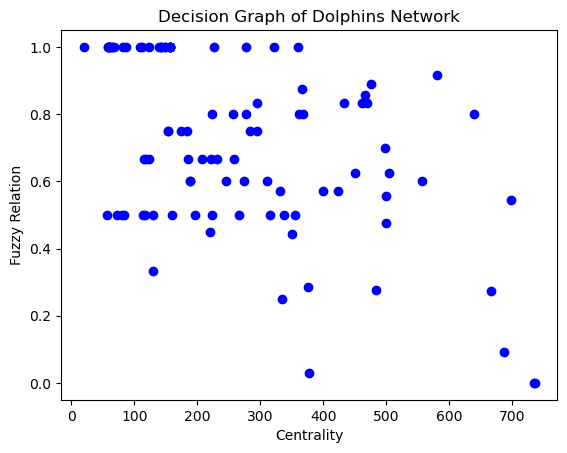

In [114]:
import matplotlib.pyplot as plt

def decisionGraphs(G, datasetName):
    fuzzies = list()

    #retrieve fuzzy relations of all nodes
    for V in G.nodes():
        ngc, fr = findNGCandFuzzyRelation(G, V)
        fuzzies.append(fr)

    #get centrality of all nodes
    centralities = list(centralityOfNodes(G).values())

    plt.title("Decision Graph of {}".format(datasetName))
    plt.xlabel('Centrality')
    plt.ylabel('Fuzzy Relation')
    plt.scatter(centralities, fuzzies, c="b")
    
    # save image of decision graph
    filename = datasetName.replace(" ", "_").lower()
    plt.savefig("graphs/refined/decisions/{}".format(filename+"_refined_decision_graph"+".png"), format="PNG", dpi=400)


K = nx.karate_club_graph()
D = nx.read_gml("datasets/dolphins.gml")
# P = nx.read_gml("datasets/us_politics_books.gml")
# F = nx.read_gml("datasets/football.gml")
# FB = nx.read_edgelist("datasets/facebook686.edges")
# # FB = nx.read_edgelist("datasets/facebook414.edges")
# T = nx.read_edgelist("datasets/twitter.edges")
# GP = nx.read_edgelist("datasets/googleplus.edges")

D = nx.convert_node_labels_to_integers(D,first_label=0)
# P = nx.convert_node_labels_to_integers(P,first_label=0)
# F = nx.convert_node_labels_to_integers(F,first_label=0)
# FB = nx.convert_node_labels_to_integers(FB,first_label=0)

decisionGraphs(K, "Karate Club")
decisionGraphs(D, "Dolphins Network")
# decisionGraphs(P, "US Politics Books")
# decisionGraphs(F, "Football")
# decisionGraphs(FB, "Facebook 686 Edges")
# decisionGraphs(T, "Twitter")
# decisionGraphs(GP, "Google Plus")
